# Advanced lane finding project

In [1]:
# Importing required libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline
print('Library import successful')

Library import successful


### Calibrating the camera

In [11]:
def calibrate_camera():
    
    # prepare object points
    nx = 9#TODO: enter the number of inside corners in x
    ny = 6#TODO: enter the number of inside corners in y

    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    objpoints = []
    imgpoints = []
    
    for fname in images:
            
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def test_calibration(mtx, dist):
    fname = 'camera_cal/calibration1.jpg'
    img = cv2.imread(fname)

    un_dst = cv2.undistort(img, mtx, dist, None, mtx)

    plt.imshow(un_dst)
    
def perspective_transform():
    
    fname = 'test_images/straight_lines1.jpg'
    img = cv2.imread(fname)
    
    offset_x = 300 # offset for dst points
    offset_y = 100
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[410,580], [890, 580], [1040, 680], [260, 680]])
    #src = np.float32([[580,410], [ 580, 890], [ 680, 1040], [ 680, 260]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset_x, offset_y], [img_size[0]-offset_x, offset_y], 
                                 [img_size[0]-offset_x, img_size[1]-offset_y], 
                                 [offset_x, img_size[1]-offset_y]])
    #dst = np.float32([[300,300], [1000,300], [1000,700], [300,700]])
    
    print(dst)
    #print(dst1)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    
    
    return M, img_size

print('functions defined')

functions defined


In [12]:
def abs_sobel_threshold(img, sobel_kernel=3, thresh=(20, 100)):
    # Calculate directional gradient
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    return scaled_sobelx, scaled_sobely

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255), thresh=(20, 100)):
    sobelx, sobely = abs_sobel_threshold(img, sobel_kernel, thresh)
    
    mag_sobel = ((sobelx*sobelx)+(sobely*sobely))**(1/2)
    
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output, sobelx, sobely

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2), thresh=(20, 100)):
    
    sobelx, sobely = abs_sobel_threshold(img, sobel_kernel, thresh)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output, sobelx, sobely

def combined_sobel_threshold(img, sobel_kernel=15, thresh=(100, 230), mag_thresh=(100, 230), dir_thresh=(0, np.pi/2)):
    mag_binary, sobelx, sobely = mag_threshold(img, sobel_kernel, mag_thresh, thresh)
    dir_binary, sobelx, sobely = dir_threshold(img, sobel_kernel, dir_thresh, thresh)
    combined = np.zeros_like(sobelx)
    combined[((sobelx == 1) & (sobely == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

print('functions defined')

functions defined


In [13]:
def get_s_channel_binary(img, threshold=(90, 255)):
    s_channel = img[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= threshold[0]) & (s_channel <= threshold[1]))] = 1
    return s_binary

def get_h_channel_binary(img, threshold=(0, 60)):
    h_channel = img[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[((h_channel >= threshold[0]) & (h_channel <= threshold[1]))] = 1
    return h_binary

def combined_color_threshold(img, s_threshold=(90, 255), h_threshold=(0, 60)):
    s_binary = get_s_channel_binary(img, s_threshold)
    h_binary = get_h_channel_binary(img, h_threshold)
    
    combined = np.zeros_like(s_binary)
    combined[(s_binary == 1) & (h_binary == 1)] = 1
    return combined

In [14]:
def combined_sobel_color_threshold(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    plt.figure()
    
    combined_sobel = combined_sobel_threshold(gray)
    combined_sobel = np.uint8(combined_sobel)
    #print(combined_sobel.nonzero()[0].shape)
    #print(combined_sobel.max())
    #print(combined_sobel.dtype)
    plt.imshow(combined_sobel, cmap='gray')
    plt.figure()
    
    combined_color = combined_color_threshold(img)
    plt.imshow(combined_color, cmap='gray')
    plt.figure()
    
    combined = np.zeros_like(combined_sobel)
    combined[(combined_sobel == 1) & (combined_color == 1)] = 1
    return combined

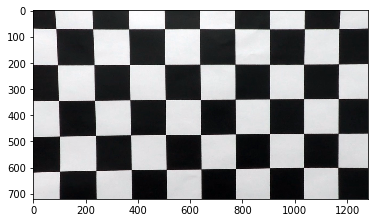

In [15]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

test_calibration(mtx, dist)

In [16]:
M, img_size = perspective_transform()

[[300. 100.]
 [980. 100.]
 [980. 620.]
 [300. 620.]]


In [17]:
def find_lanelines(img, mtx, dist, M, img_size):
    un_dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(un_dst)
    plt.figure()
    
    hls = cv2.cvtColor(un_dst, cv2.COLOR_BGR2HLS)
    plt.imshow(hls)
    plt.figure()
    
    warped = cv2.warpPerspective(hls, M, img_size)
    plt.imshow(warped)
    plt.figure()
    
    combined = combined_sobel_color_threshold(warped)
    plt.imshow(combined, cmap='gray')
    plt.figure()
    
    histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
    plt.plot(histogram)

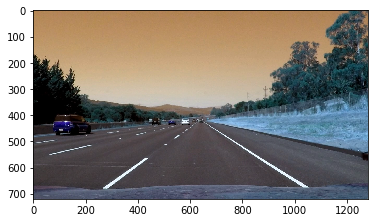

In [22]:
fname = 'test_images/straight_lines2.jpg'
#fname = 'test_images/test5.jpg'
img = cv2.imread(fname)
plt.imshow(img)


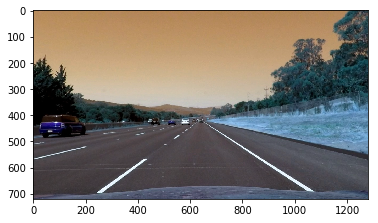

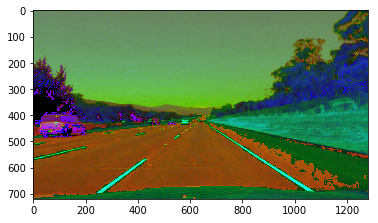

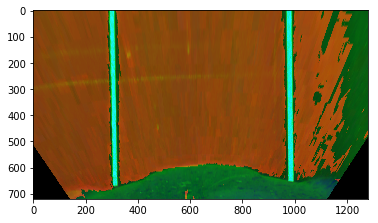

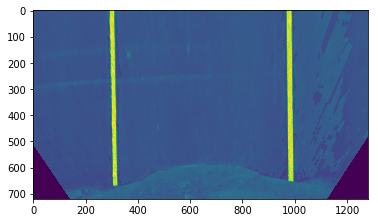

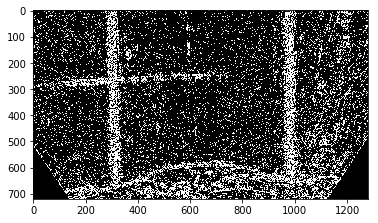

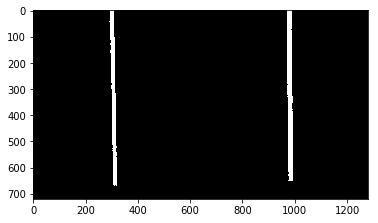

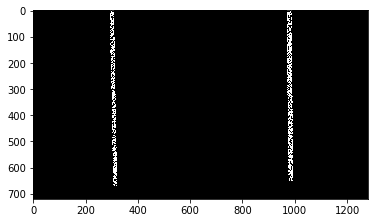

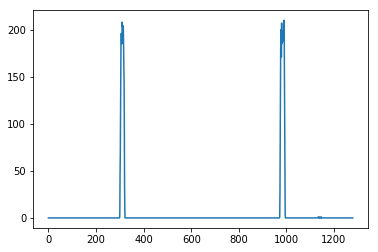

In [23]:
find_lanelines(img, mtx, dist, M, img_size)